# AT&T Spam Detector - BLOC 5
## PART 4 : DistilBERT + logistic Regression with PyTorch
Developed by Myriam Goyet     
Contact : https://www.linkedin.com/in/myriamgoyet/

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import time
import random
import string
import torch
import joblib
import os, shutil, joblib, json


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight 

from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import re

# 1. Load dataset and model

In [21]:
df4 = pd.read_csv('AT&T_data_preprocessed.csv')
# Replace missing values with an empty string and convert everything to strings
df4['clean_data'] = df4['clean_data'].fillna('').astype(str)

In [ ]:
df4.head() 

,target,messages,clean_data,clean_lemma
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives arou...,nah think usf live


In [23]:
# Loading pretrained model/tokenizer compatible with PyTorch
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 2. Preprocessing and Embedding with DistilBERT

In [24]:
# tokenisation of the messages
tokenized = df4['clean_data'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# get the length of the longest tokenized sentence
max_len = tokenized.apply(len).max() 
# padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) 
# Tell our model to ignore every zeros
attention_mask = np.where(padded != 0, 1, 0)



In [25]:
max_len

204

In [26]:
# Convert to PyTorch tensors with appropriate data types
input_ids = torch.tensor(padded, dtype=torch.long)  # Use torch.long for input_ids
attention_mask = torch.tensor(attention_mask, dtype=torch.bool)  # Use torch.bool for attention_mask

In [27]:
# Check shapes and types
print("Input IDs shape:", input_ids.shape)
print("Attention Mask shape:", attention_mask.shape)
print("Input IDs type:", input_ids.dtype)
print("Attention Mask type:", attention_mask.dtype)

Input IDs shape: torch.Size([5169, 204])
Attention Mask shape: torch.Size([5169, 204])
Input IDs type: torch.int64
Attention Mask type: torch.bool


In [28]:
def extract_features_in_batches(model, input_ids, attention_mask, df4, batch_size=64):
    model.eval()
    all_X = []
    all_y = []

    for start_idx in range(0, len(input_ids), batch_size):
        end_idx = start_idx + batch_size

        # Slice the batch
        batch_input_ids = input_ids[start_idx:end_idx]
        batch_attention_mask = attention_mask[start_idx:end_idx]
        batch_df = df4.iloc[start_idx:end_idx]

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
            cls_embeddings = hidden_states[:, 0, :].cpu().numpy()  # (batch_size, hidden_size)

        # Only use DistilBERT CLS token embeddings
        batch_X = cls_embeddings
        batch_y = batch_df["target"].to_numpy()

        all_X.append(batch_X)
        all_y.append(batch_y)

    X = np.vstack(all_X)
    y = np.concatenate(all_y)

    return X, y


In [29]:
X, y = extract_features_in_batches(model, input_ids, attention_mask, df4, batch_size=64)

print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)


✅ X shape: (5169, 768)
✅ y shape: (5169,)


In [30]:
import os
import json
import numpy as np

def save_distilbert_features_and_model(
    model,
    tokenizer,
    X,
    y,
    output_dir="Models_trained/DistilBERT+lr/DistilBERT_features"
):
    # Clean save directory
    if os.path.exists(output_dir):
        import shutil
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # 1. Save features
    np.save(os.path.join(output_dir, "features_X.npy"), X)
    np.save(os.path.join(output_dir, "labels_y.npy"), y)

    # 2. Save DistilBERT model (PyTorch format)
    model.save_pretrained(os.path.join(output_dir, "distilbert_model"))

    # 3. Save tokenizer
    tokenizer.save_pretrained(os.path.join(output_dir, "tokenizer"))

    # 4. Save metadata 
    metadata = {
        "X_shape": X.shape,
        "y_shape": y.shape,
        "embedding_dim": X.shape[1],
        "model_type": "DistilBERT"
    }
    with open(os.path.join(output_dir, "meta.json"), "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"✅ DistilBERT features and model saved in: {output_dir}")


In [31]:
save_distilbert_features_and_model(
    model=model,
    tokenizer=tokenizer,
    X=X,
    y=y,
    output_dir="Models_trained/DistilBERT+lr/DistilBERT_features")

✅ DistilBERT features and model saved in: Models_trained/DistilBERT+lr/DistilBERT_features


# 3. Use the emdedded feature to train a Logistic regression model

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

classification_report train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3386
           1       1.00      1.00      1.00       490

    accuracy                           1.00      3876
   macro avg       1.00      1.00      1.00      3876
weighted avg       1.00      1.00      1.00      3876

classification_report test set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1130
           1       0.96      0.94      0.95       163

    accuracy                           0.99      1293
   macro avg       0.98      0.97      0.97      1293
weighted avg       0.99      0.99      0.99      1293



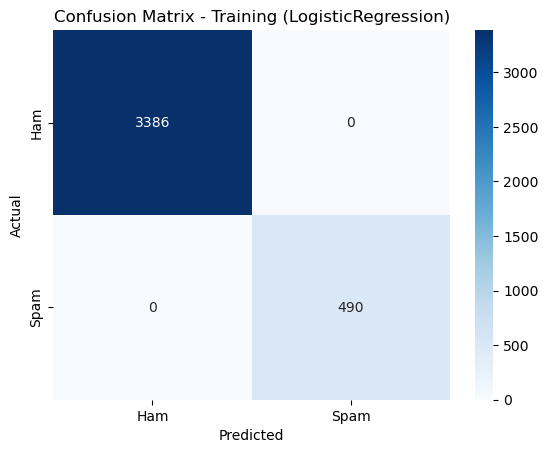

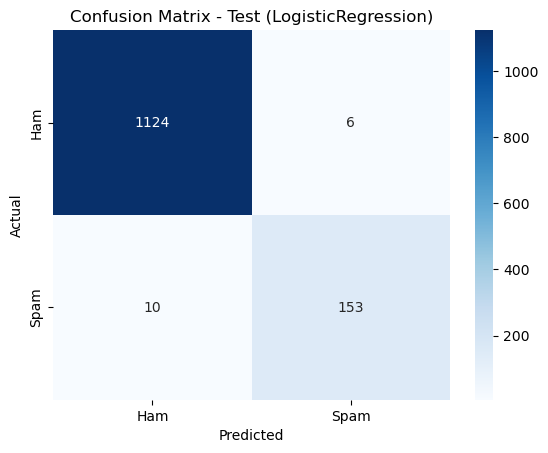

In [33]:
model_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model_lr.fit(X_train, y_train)
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)
model_name ="LogisticRegression"

# Classification report
print("classification_report train set")
print(classification_report(y_train, y_pred_train))
print("classification_report test set")
print(classification_report(y_test, y_pred_test))

# Heatmaps confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f"Confusion Matrix - Training ({model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print()
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f"Confusion Matrix - Test ({model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




Youhou!! Our model's metrics are excellent!!

# Saving model and metrics

In [34]:
def save_full_pipeline_and_classifier(
    distilbert_model,
    tokenizer,
    classifier_pipeline,
    X,
    y,
    threshold=None,
    output_dir="Models_trained/DistilBERT+lr/final_pipeline"
):
    # 1. Reset save directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # 2. Save DistilBERT model (PyTorch)
    distilbert_model.save_pretrained(os.path.join(output_dir, "distilbert_model"))

    # 3. Save tokenizer
    tokenizer.save_pretrained(os.path.join(output_dir, "tokenizer"))

    # 4. Save classifier pipeline (StandardScaler + LogisticRegression)
    joblib.dump(classifier_pipeline, os.path.join(output_dir, "classifier_pipeline.joblib"))

    # 5. Save features
    np.save(os.path.join(output_dir, "features_X.npy"), X)
    np.save(os.path.join(output_dir, "labels_y.npy"), y)

    # 6. Save metadata
    metadata = {
        "model_type": "DistilBERT + LogisticRegression",
        "embedding": "CLS token",
        "features": ["CLS embedding"],
        "tokenizer": tokenizer.name_or_path,
        "X_shape": X.shape,
        "y_shape": y.shape,
        "threshold_used": round(threshold, 4) if threshold else "default (0.5)",
        "notes": "Built using HuggingFace DistilBERT CLS embeddings and scikit-learn pipeline. No handcrafted features included."
    }
    with open(os.path.join(output_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"✅ Full DistilBERT pipeline saved to: {output_dir}")


In [ ]:
save_full_pipeline_and_classifier(
    distilbert_model = model,
    tokenizer = tokenizer,
    classifier_pipeline = model_lr,
    X=X,
    y=y,
    threshold=None,
    output_dir="Models_trained/DistilBERT+lr/final_pipeline"
)

In [ ]:
def save_metrics_and_reports(
    report_train,
    report_test,
    cm_train,
    cm_test,
    threshold=None,
    eval_dir="Evaluations"
):
    os.makedirs(eval_dir, exist_ok=True)

    # Save classification reports
    with open(os.path.join(eval_dir, "classification_report_train.json"), "w") as f:
        json.dump(report_train, f, indent=4)
    with open(os.path.join(eval_dir, "classification_report_test.json"), "w") as f:
        json.dump(report_test, f, indent=4)

    # Save summary metrics
    summary = {
        "train_f1": report_train["weighted avg"]["f1-score"],
        "train_precision": report_train["weighted avg"]["precision"],
        "train_recall": report_train["weighted avg"]["recall"],
        "train_accuracy": report_train["accuracy"],
        "test_f1": report_test["weighted avg"]["f1-score"],
        "test_precision": report_test["weighted avg"]["precision"],
        "test_recall": report_test["weighted avg"]["recall"],
        "test_accuracy": report_test["accuracy"]
    }
    with open(os.path.join(eval_dir, "metrics_summary.json"), "w") as f:
        json.dump(summary, f, indent=4)

    # Save threshold
    if threshold is not None:
        with open(os.path.join(eval_dir, "threshold.json"), "w") as f:
            json.dump({"threshold": round(threshold, 4)}, f)

    # Save confusion matrices
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title("Confusion Matrix - Training")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(os.path.join(eval_dir, "confusion_matrix_train.png"))
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title("Confusion Matrix - Validation")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(os.path.join(eval_dir, "confusion_matrix_test.png"))
    plt.close()

    print(f"✅ Evaluation reports saved to: {eval_dir}")


In [35]:
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

save_metrics_and_reports(
    report_train=report_train,
    report_test=report_test,
    cm_train=cm_train,
    cm_test=cm_test,
    threshold=None,
    eval_dir="Evaluations/DistilBERT_lr"
)


NameError: name 'save_metrics_and_reports' is not defined